<a href="https://colab.research.google.com/github/vsiningl/UMDProjects/blob/main/436FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
import torchvision.models as models
from torch.utils.data import Subset
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.optim as optim
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
!pip install opendatasets
!pip install pandas

In [ ]:
import opendatasets as od
import pandas
#redeathailu
#9c01b3a083a313796e3f8471a1831178
od.download(
    "https://www.kaggle.com/datasets/kipshidze/drunk-vs-sober-infrared-image-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: redeathailu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kipshidze/drunk-vs-sober-infrared-image-dataset


100%|██████████| 1.45M/1.45M [00:00<00:00, 661MB/s]

{'20mins': 0, '40mins': 1, '60mins': 2, 'sober': 3}
Train class counts: Counter({0: 74, 3: 73, 1: 72, 2: 72})
Val class counts: Counter({0: 49, 3: 49, 1: 49, 2: 48})
486
291
195


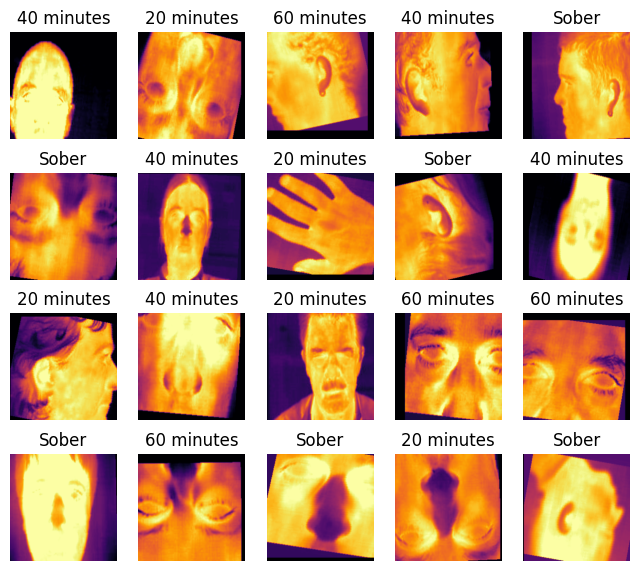

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(256, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

validation_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(256),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset WITHOUT transforms
base_dataset = torchvision.datasets.ImageFolder(
    root="./drunk-vs-sober-infrared-image-dataset/drunk_sober_data"
)

print(base_dataset.class_to_idx)

# Get all image paths and their labels from the ImageFolder
all_imgs = base_dataset.imgs  # list of (filepath, class_idx)
all_paths = [x[0] for x in all_imgs]
all_labels = [x[1] for x in all_imgs]

# Stratified split so class balance is preserved
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_paths, all_labels, test_size=0.4, stratify=all_labels, random_state=42
)

# Rebuild the datasets with transforms applied manually
train_dataset = [(train_transform(Image.open(path).convert('RGB')), label) for path, label in zip(train_paths, train_labels)]
val_dataset   = [(validation_transform(Image.open(path).convert('RGB')), label) for path, label in zip(val_paths, val_labels)]

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# Print class counts to confirm stratified split worked
print("Train class counts:", Counter(train_labels))
print("Val class counts:", Counter(val_labels))

x_sample, y_sample = next(iter(train_loader))
labels = {
    3: "Sober",
    2: "60 minutes",
    1: "40 minutes",
    0: "20 minutes"
}

print(len(base_dataset))
print(len(train_dataset))
print(len(val_dataset))

plt.figure(figsize=(8, 7))
plt.axis(False)
for i in range(1, 4 * 5 + 1):
    plt.subplot(4, 5, i)
    plt.title(labels[y_sample[i].item()])
    plt.imshow(x_sample[i].permute(1, 2, 0), cmap="inferno")
    plt.axis(False)

In [ ]:
"""
# make the cnn much smaller, it's much too large for the dataset we are using
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(8 * 32 * 32, 32)
        self.fc2 = nn.Linear(32, 4)

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = F.relu(self.pool3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

"""

# try the resnet18 pretrained model
def get_resnet18_model():
    model = models.resnet18(pretrained=True)

    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4)

    return model


In [ ]:
model = get_resnet18_model()
"""
# freezing the layers of the model
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(model)

test_input = torch.randn(4, 1, 256, 256)
output = model(test_input) # [4,4]
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

criterion = nn.CrossEntropyLoss()

random_targets = torch.randint(0, 4, (4,))
initial_loss = criterion(output, random_targets)
print(f"Initial loss: {initial_loss.item():.4f}")


In [ ]:
model = get_resnet18_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

EPOCHS = 30

CHECKPOINT_FOLDER = "./saved_model"

best_val_acc = 0.0
#0.05 is tooooo high
#current_learning_rate = 0.05
current_learning_rate = 0.0001

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=current_learning_rate, weight_decay=1e-4)
#optimizer = optim.SGD(model.parameters(), lr=current_learning_rate, momentum=0.9, weight_decay=1e-4)

#resnet18
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
#smallcnn
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

print("==> Training starts!")
print("="*50)
for i in range(1,EPOCHS):

    model.train()

    print("Epoch %d:" %i)
    total_examples = 0
    correct_examples = 0

    train_loss = 0.0

    for batch_idx, (inputs, targets) in enumerate(train_loader):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # add noise, commented out because maybe it is too much for a small dataset?
        # noise = torch.randn_like(inputs) * 0.3
        # inputs = torch.clamp(inputs + noise, 0, 1)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct = predicted.eq(targets).sum().item()
        correct_examples += correct
        total_examples += targets.size(0)

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_losses.append(avg_loss)
    train_accuracies.append(avg_acc)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    model.eval()

    total_examples = 0
    correct_examples = 0

    val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets.long())
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            correct = predicted.eq(targets).sum().item()
            correct_examples += correct
            total_examples += targets.size(0)

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_losses.append(avg_loss)
    val_accuracies.append(avg_acc)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    scheduler.step()

    print('')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend()
plt.show()

"""
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels.values(), yticklabels=labels.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(all_labels, all_preds, target_names=labels.values()))
"""
""""
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': model.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplecnn.pth'))
"""
"""
for i in train_dataset:
  print
print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")
"""

In [ ]:

test_loader = DataLoader(
    test_set, batch_size=8,
    num_workers=2
)

print(test_loader)

def evaluate_test_set(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    test_loss = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets.long())
            test_loss += loss.item()

            _, predicted = outputs.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    test_loss /= len(test_loader)
    correct = sum(p == t for p, t in zip(all_predictions, all_targets))
    accuracy = correct / len(all_targets)

    print(f"Test loss: {test_loss:.4f}, Test accuracy: {accuracy:.4f}")

    return all_predictions, all_targets, test_loss, accuracy

all_predictions, all_targets, test_loss, accuracy = evaluate_test_set(model, test_loader, device)